# computing the electrical distance between points on the cell

We would like to compute the electrical distance between the postsynaptic sites on a rosette. This requires using the SWC file and validating:

1. Can we map locations in the json to the corresponding location in the swc? How much slop is there? Do we need to take radius into effect? 
2. Can we compute the distance between two points in the SWC graph? We need to take into account spatial distance as well as the radius


If i think of each edge as specifying a conical frustum we should be able to specify the effective electrical connectivity 




In [1]:
%pylab inline
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
import cPickle as pickle
import os
import sys
sys.path.append("../")

Populating the interactive namespace from numpy and matplotlib


In [2]:
neurons_data = pickle.load(open("../data/mushroombody.neurondf.pickle", 'r'))
neurons_df = neurons_data['neurondf']

neuronsdf = neurons_df.set_index('body ID')
neuronsdf['name_clean'] = neuronsdf.name.apply(lambda x: str(x))

In [3]:
TGT_NEURON = 'MBON-14-A'

In [4]:
TGT_BODY_ID = neuronsdf[neuronsdf.name_clean == TGT_NEURON].iloc[0].name
print TGT_BODY_ID

1661302


In [5]:
# from http://www.neuronland.org/NLMorphologyConverter/MorphologyFormats/SWC/Spec.html
d = pd.read_csv("../../data.original/mushroombody/skeletons/{:d}.swc".format(TGT_BODY_ID), sep=" ", header=None)
d.columns = ['samplenum', 'struct', 'x', 'y', 'z', 'radius', 'parent']
d = d.set_index('samplenum')

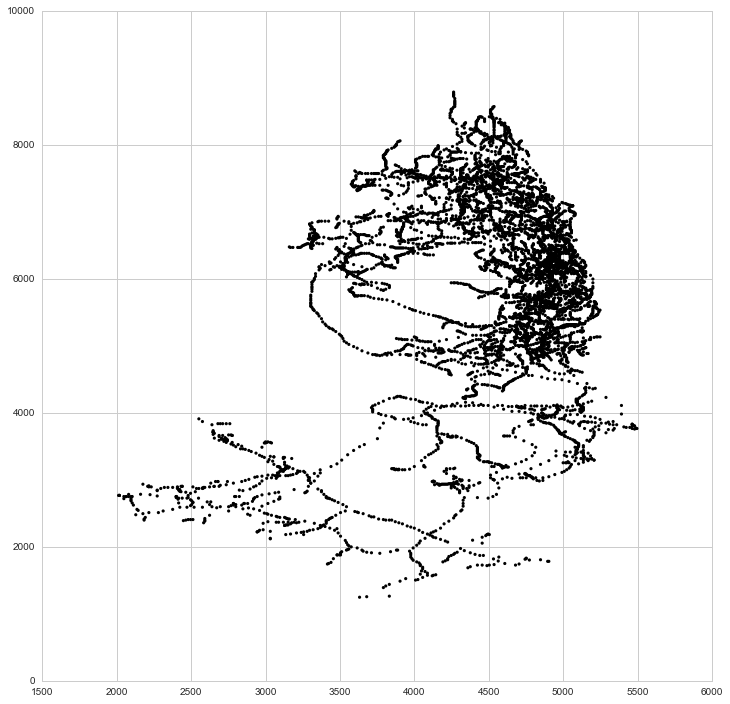

In [6]:
fig = pylab.figure(figsize=(12, 12))
sub = d[d.struct ==0]
pylab.scatter(sub.x, sub.z, c='k', edgecolor='none', s=10)


In [7]:
D = np.load("../data/graph.{:d}.length_resistance.npy".format(TGT_BODY_ID), mmap_mode='r')
D_meta = pickle.load(open("../data/graph.{:d}.length_resistance.pickle".format(TGT_BODY_ID), 'r'))
tbar_close_edges = pickle.load(open("../data/graph.{:d}.tbar_edge.pickle".format(TGT_BODY_ID), 'r'))

In [8]:
out_node_pos_dict = D_meta['out_node_pos_dict']


In [9]:
tbar_closest_distance_df = tbar_close_edges['tbar_closest_distance_df']
tbar_to_node_lut = {ri: (int(r.n1), int(r.n2), r.normalized_line_intercept) for ri, r in tbar_closest_distance_df.iterrows() }

In [10]:
synapse_data = pickle.load(open("../data/mushroombody.synapsesdf.pickle", 'r'))
tbar_df = synapse_data['tbar_df']
connections_df = synapse_data['connections_df']

dfmerged = pd.merge( connections_df, tbar_df, left_on='tbar_id', 
                    right_on='id', suffixes=('_post', '_pre'))
dfmerged.convergent = dfmerged.convergent == 'convergent'
dfmerged.dtypes

# now try and create a matrix of KC-KC resistivity through a MBON
dfmerged_mbon_post = dfmerged[dfmerged['body ID_post'] == TGT_BODY_ID].copy()


In [11]:
from numba import jit
@jit(nopython=True)
def path_distance_compute_pair(ni1_nj1, ni1_nj2, ni2_nj1, ni2_nj2, t_i, t_j):
    """
    I have four points on a line and I don't know their ordering. I know my line is
    11 12 21 22
    11 12 22 21
    12 11 21 22
    12 11 22 21
    
    Ugh this is a mess
    """
    # if any instances are zero we special case:
    
    # else we find the smallest distance and set that as our anchor
    pos = np.argmin(np.array([ni1_nj1, ni1_nj2, ni2_nj1, ni2_nj2]))
    delta_i = np.abs(ni1_nj1 - ni2_nj1)
    delta_j = np.abs(ni1_nj1 - ni1_nj2)

    if ni1_nj1 == 0  and ni2_nj2 == 0:  
        # ni1 and nj1 align, ni_2, and nj_2
        return ni1_nj2 * np.abs(t_i - t_j)
    elif ni1_nj2 == 0  and ni2_nj1 == 0:  
        # anti-aligned
        return ni1_nj1 * np.abs(t_i - t_j)    
    
    if pos == 0:
        # ni2 ni1 nj1 nj2
        return ni1_nj1 + t_i * delta_i + t_j * delta_j
    elif pos == 1:
        # ni2 ni1 nj2 nj1
        return ni1_nj2 + t_i * delta_i + (1-t_j) * delta_j
    elif pos == 2:
        # ni1 ni2 nj1 nj2
        return ni2_nj1 + (1-t_i) * delta_i + (t_j) * delta_j
    elif pos == 3:
        # ni1 ni2 nj2 nj1
        return ni2_nj2 + (1-t_i) * delta_i + (1-t_j) * delta_j
    else:
        raise NotImplementedError()
    
        

    
# 1(0.25) 2,<- 1.0 -> 3(0.75) 4 
print path_distance_compute_pair(2, 3, 1, 2, 0.25, 0.75) # should be 2.5
# 1(0.75) 2,<- 1.0 -> 3(0.25) 4 
print path_distance_compute_pair(2, 3, 1, 2, 0.75, 0.25) # should be 1.5
# i2 (0.4) i1 <- 2.0 -> j2 (0.25) j1 
print path_distance_compute_pair(3, 2, 4, 3, 0.4, 0.25) # should be 2 + 0.4 + 0.75 = 3.15

# overlap 
print path_distance_compute_pair(0, 1, 1, 0, 0.4, 0.25) # 0.15
print path_distance_compute_pair(1, 0, 0, 1, 0.4, 0.25) # 0.15
    
# single node overlap
# ni_1 0.3 (ni_2, nj_1) 0.3  nj_2
print path_distance_compute_pair(1, 2, 0, 1, 0.3, 0.3) # 1.0

# ni_1 0.3 (ni_2, nj_2) 0.3  nj_1
print path_distance_compute_pair(2, 1, 1, 0, 0.3, 0.3) # 1.4



2.5
1.5
3.15
0.15
0.15
1.0
1.4


In [12]:
df = dfmerged_mbon_post[['body ID_pre', 'tbar_id']].copy()


pre_cell_tbars = {}
for pre_cell_i, pre_cell_i_tbars in df.groupby('body ID_pre'):
    pre_cell_tbars[pre_cell_i] = np.array(pre_cell_i_tbars.tbar_id)

print np.min(out_node_pos_dict.keys())
print np.max(out_node_pos_dict.keys())
out_node_pos_array = np.zeros(np.max(out_node_pos_dict.keys()) + 1, dtype=int)
for k, v in out_node_pos_dict.iteritems():
    out_node_pos_array[k] = v    
    
resistance_df = []

# load tf_node graph
for ci, (pre_cell_i, pre_cell_i_tbars) in enumerate(pre_cell_tbars.iteritems()):
    print ci, len(pre_cell_tbars), pre_cell_i
    for pre_cell_j, pre_cell_j_tbars in pre_cell_tbars.iteritems():
        if pre_cell_j < pre_cell_i:
            continue
            
        cell_resistances = []
        for cell_i_tbar in pre_cell_i_tbars:
            node_i_n1, node_i_n2, node_i_t = tbar_to_node_lut[cell_i_tbar]
            pos_i_n1   = out_node_pos_array[node_i_n1]
            pos_i_n2   = out_node_pos_array[node_i_n2]
            
            for cell_j_tbar in pre_cell_j_tbars:
                node_j_n1, node_j_n2, node_j_t = tbar_to_node_lut[cell_j_tbar]
                pos_j_n1   = out_node_pos_array[node_j_n1]
                pos_j_n2   = out_node_pos_array[node_j_n2]                
                
                d_1_1 = D[pos_i_n1, pos_j_n1]
                d_2_1 = D[pos_i_n2, pos_j_n1]
                
                d_1_2 = D[pos_i_n1, pos_j_n2]
                d_2_2 = D[pos_i_n2, pos_j_n2]
                
                if np.isfinite(d_1_1) and np.isfinite(d_1_2) and np.isfinite(d_2_1) and np.isfinite(d_2_2):
                    
                    computed_d = path_distance_compute_pair(d_1_1, d_1_2, d_2_1, d_2_2, node_i_t, node_j_t)
                else:
                    computed_d = np.inf
                    

                cell_resistances.append(computed_d)
        resistance_df.append({'cell_i': pre_cell_i, 'cell_j' : pre_cell_j, 'resistances' : cell_resistances})

1
7808
0 281 3503107
1 281 1
2 281 3345411
3 281 705540
4 281 6
5 281 1107122
6 281 3265964
7 281 2095117
8 281 8839586
9 281 2052113
10 281 3023890
11 281 3323003
12 281 2963476
13 281 11876099
14 281 2236953
15 281 5143579
16 281 4010012
17 281 1370653
18 281 1787423
19 281 2466849
20 281 3347291
21 281 603173
22 281 1869350
23 281 10011689
24 281 4109866
25 281 5735356
26 281 954925
27 281 5122860
28 281 1810481
29 281 6727617
30 281 631859
31 281 4898654
32 281 3401270
33 281 6920759
34 281 1939512
35 281 3594847
36 281 2990140
37 281 3677248
38 281 328519763
39 281 2583108
40 281 1190582
41 281 1791047
42 281 3384907
43 281 3127884
44 281 4100420
45 281 2164305
46 281 5183570
47 281 3154515
48 281 898132
49 281 400643001
50 281 3426904
51 281 5469273
52 281 1662042
53 281 1785436
54 281 702821
55 281 164450
56 281 3269733
57 281 2026086
58 281 3422225
59 281 4401769
60 281 3330155
61 281 5288960
62 281 1559661
63 281 3782254
64 281 10243311
65 281 802928
66 281 12253991
67 281 542

In [13]:
resistance_df = pd.DataFrame(resistance_df)

In [14]:
pre_ids_unique = np.sort(np.unique(dfmerged_mbon_post['body ID_pre']))
pre_ids_to_pos = {k:v for v, k in enumerate(pre_ids_unique)}
PRE_CELL_N = len(pre_ids_unique)


In [15]:
conmat = np.zeros((PRE_CELL_N, PRE_CELL_N))

In [16]:
for ri, r in resistance_df.iterrows():
    pos_i = pre_ids_to_pos[r.cell_i]
    pos_j = pre_ids_to_pos[r.cell_j]
    if len(r.resistances) > 0:
        conmat[pos_i, pos_j] = np.sum(1.0/np.array(r.resistances))
    

In [17]:
conmat_sym = conmat + conmat.T


In [18]:
for ri, r in resistance_df.iterrows():
    if not np.isfinite(r.resistances).all():
        print ri, r
        break

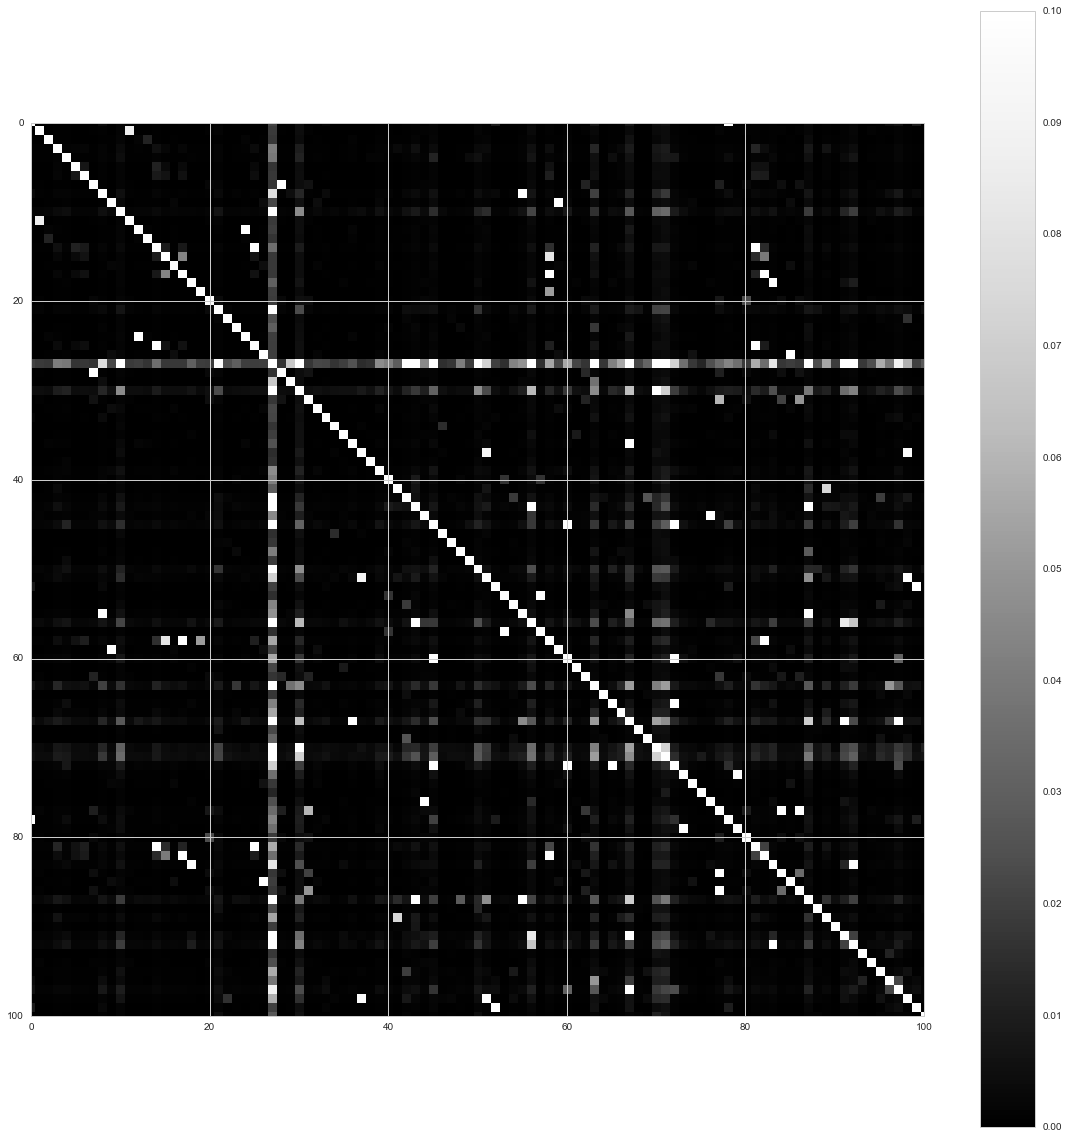

In [19]:
pylab.figure(figsize=(20, 20))
pylab.imshow(conmat_sym, interpolation='nearest', vmin=0, vmax=0.1, cmap=pylab.cm.Greys_r)
pylab.xlim(0, 100)
pylab.ylim(100, 0)
pylab.colorbar()

In [20]:
np.max(conmat_sym)

inf

array([ 95,  89,  90,  91,  92,  93,  94,  96,  87,  97,  98,  99, 100,
       101, 102,  88,  86, 139,  77,  71,  72,  73,  74,  75,  76,  78,
        85,  79,  80,  81,  82,  83,  84, 103, 104, 105, 130, 124, 125,
       126, 127, 128, 129, 131, 106, 132, 133, 134, 135, 136, 137, 123,
       122, 121, 120, 119, 118, 117, 116, 115, 114, 113, 112, 111, 110,
       109, 108, 107,  70,  69,  68,  24,  18,  19,  20,  21,  22,  23,
        25,  33,  26,  27,  28,  29,  30,  31,  17,  16,  15,  14,  13,
        12,  11,  10,   9,   8,   7,   6,   5,   4,   3,   2,   1,  32,
        34,  67,  59,  53,  54,  55,  56,  57,  58,  60,  35,  61,  62,
        63,  64,  65,  66,  52,  51,  50,  49,  48,  47,  46,  45,  44,
        43,  42,  41,  40,  39,  38,  37,  36, 138, 140, 279, 236, 230,
       231, 232, 233, 234, 235, 237, 228, 238, 239, 240, 241, 242, 243,
       229, 227, 141, 218, 212, 213, 214, 215, 216, 217, 219, 226, 220,
       221, 222, 223, 224, 225, 244, 245, 246, 271, 265, 266, 26

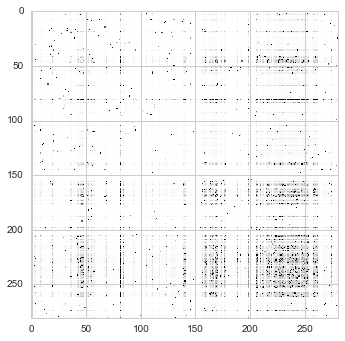

In [21]:
import scipy.cluster.hierarchy as hier


def plot_zmatrix(ax, zmatrix, **kwargs):
    from matplotlib import pylab

    lm = hier.linkage(zmatrix)
    ord = np.array(hier.leaves_list(lm))
    
    ax.imshow((zmatrix[ord])[:, ord], interpolation='nearest', 
              cmap=pylab.cm.Greys, **kwargs)
    return ord
fig = pylab.figure()
ax = fig.add_subplot(1,1,1)
plot_zmatrix(ax, conmat_sym, vmin=0, vmax=0.3)

In [22]:
import sklearn.cluster
conmat_sym_finite = conmat_sym.copy()
conmat_sym_finite[np.isinf(conmat_sym_finite)] = 10000


from sklearn.cluster import DBSCAN, KMeans



In [23]:
from sklearn.manifold import MDS, TSNE
m = TSNE(metric='precomputed', n_components=2, verbose=2, 
         learning_rate=100.0, n_iter_without_progress=100)
m.fit(1./conmat_sym_finite)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 281 / 281
[t-SNE] Mean sigma: 3.090931
[t-SNE] Iteration 25: error = 1.2276851, gradient norm = 0.0198685
[t-SNE] Iteration 50: error = 1.1359280, gradient norm = 0.0162674
[t-SNE] Iteration 75: error = 0.9406400, gradient norm = 0.0043499
[t-SNE] Iteration 100: error = 0.9177490, gradient norm = 0.0038248
[t-SNE] Error after 100 iterations with early exaggeration: 0.917749
[t-SNE] Iteration 125: error = 0.8853416, gradient norm = 0.0032290
[t-SNE] Iteration 150: error = 0.8763519, gradient norm = 0.0030647
[t-SNE] Iteration 175: error = 0.8740770, gradient norm = 0.0030483
[t-SNE] Iteration 200: error = 0.8735701, gradient norm = 0.0030065
[t-SNE] Iteration 225: error = 0.8734277, gradient norm = 0.0030009
[t-SNE] Iteration 250: error = 0.8733906, gradient norm = 0.0030005
[t-SNE] Iteration 275: error = 0.8733760, gradient norm = 0.0030001
[t-SNE] Iteration 275: error difference 0.000000. F

TSNE(angle=0.5, early_exaggeration=4.0, init='random', learning_rate=100.0,
   method='barnes_hut', metric='precomputed', min_grad_norm=1e-07,
   n_components=2, n_iter=1000, n_iter_without_progress=100,
   perplexity=30.0, random_state=None, verbose=2)

In [24]:
#pre_ids_unique
names_clean = neuronsdf.ix[pre_ids_unique].name_clean

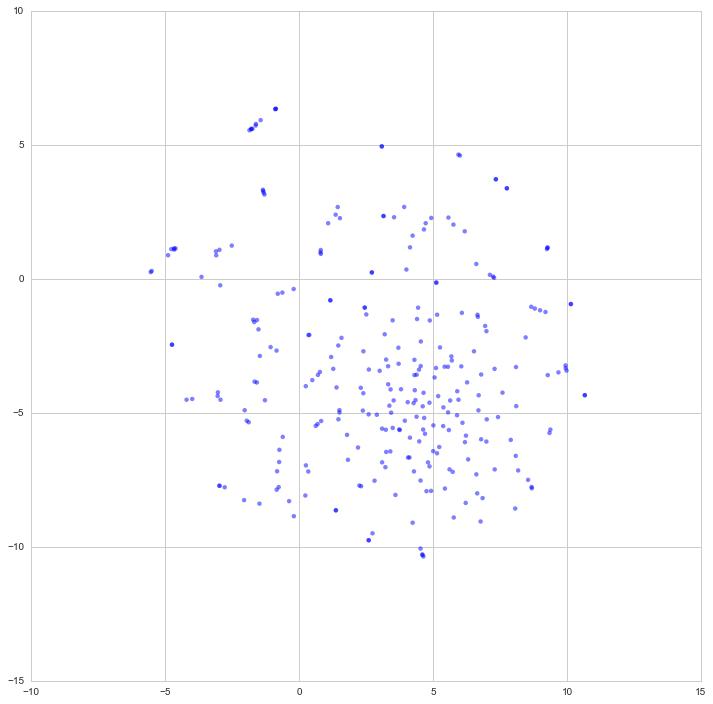

In [25]:
fig = pylab.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1)
#for n, p in zip(names_clean, m.embedding_):
#    ax.text( p[0], p[1], n) #, edgecolor='none', facecolor='k')
ax.scatter(m.embedding_[:, 0], m.embedding_[:, 1], edgecolor='none', alpha=0.5)   

In [26]:
pd.value_counts(names_clean)

KC-s              140
KC-p               78
KC-alpha prime     20
KC-any             18
KC-c                5
MBON-06             1
Others              1
PPL1-05-R           1
PPL1-05-L           1
MBON-11-L           1
MB-DPM              1
MBON-11-R           1
Name: name_clean, dtype: int64

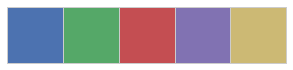

In [27]:

cp = sns.color_palette("deep", 5)
sns.palplot(cp)

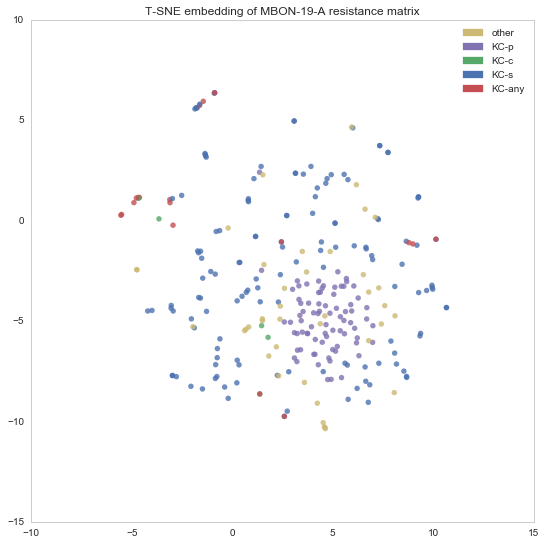

In [28]:
import matplotlib.patches 
fig = pylab.figure(figsize=(9, 9))
ax = fig.add_subplot(1, 1, 1)
#for n, p in zip(names_clean, m.embedding_):
#    ax.text( p[0], p[1], n) #, edgecolor='none', facecolor='k')
cmap = {'KC-s' : 0, 
        'KC-c' : 1, 
        'KC-any' : 2, 
        'KC-p' : 3, 
         'other' : 4}
c = []
for n in names_clean:
    if n in cmap:
        c.append(cmap[n])
    else:
        c.append(4)
        
ax.scatter(m.embedding_[:, 0], m.embedding_[:, 1], c=[cp[i] for i in c], 
           edgecolor='none', s=30, alpha=0.8)   


legend_handles = []
for n, c in cmap.iteritems():
    legend_handles.append(matplotlib.patches.Patch(color=cp[c], label=n))
pylab.legend(handles=legend_handles)
#ax.set_xlim(-5, 5.5)
#ax.set_ylim(-5, 5)
ax.grid(False)
ax.set_title("T-SNE embedding of {} resistance matrix".format(TGT_NEURON))